In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.set_palette(sns.color_palette("colorblind"))

from collections import defaultdict
from typing import List


import sys; sys.path.append("../code")
from run_experiment import readlines


BASE_DIR = "/extra/ucinlp1/cbelem/projects/bias-diagnosis"

GROUP_PAIRED_WORDLIST = [
    ("she", "he"),
    ("her", "his"),
    ("her", "him"),
    ("hers", "his"),
    ("grandmother", "grandfather"),
    ("grandma", "grandpa"),
    ("stepmother", "stepfather"),
    ("stepmom", "stepdad"),
    ("mother", "father"),
    ("mom", "dad"),
    ("aunt", "uncle"),
    ("aunts", "uncles"),
    ("mummy", "daddy"),
    ("sister", "brother"),
    ("sisters", "brothers"),
    ("daughter", "son"),
    ("daughters", "sons"),
    ("female", "male"),
    ("females", "males"),
    ("feminine", "masculine"),
    ("woman", "man"),
    ("women", "men"),
    ("madam", "sir"),
    ("matriarchy", "patriarchy"),
    ("girl", "boy"),
    ("lass", "lad"),
    ("girls", "boys"),
    ("girlfriend", "boyfriend"),
    ("girlfriends", "boyfriends"),
    ("wife", "husband"),
    ("wives", "husbands"),
    ("queen", "king"),
    ("queens", "kings"),
    ("princess", "prince"),
    ("princesses", "princes"),
    ("lady", "lord"),
    ("ladies", "lords"),
]
# unpack the previous list into female, male
FEMALE_WORDS, MALE_WORDS = zip(*GROUP_PAIRED_WORDLIST)

In [2]:
def correlation_plot(df, corr_method="kendall", figsize=(8, 5), dpi=200, **kwargs):
    print(corr_method)
    corr = df.corr(corr_method)
    mask = np.triu(corr)

    plt.figure(figsize=figsize, dpi=dpi)
    sns.heatmap(corr, mask=mask, **kwargs)

## Word-level Analysis
 
In this notebook, we conduct the post-processing and analysis at a word level. 
The notebook includes two analysis: (1) PMI, (2) diversity. 


Before delving into the comparison between the target words used in each benchmark. We first perform an analysis of how different combinations of paired gendered words correlate with one another when used to induce a word ordering in terms of how strongly associated they are with each of the words.

In [3]:
def get_pmi_diff(df: pd.DataFrame, col1: str, col2: str, clip: int=None, missing_val: float=0, prefix_col: str="pmi__") -> pd.Series:
    """Obtains the PMI difference between columns col1 and col2. 
    
    Parameters
    ----------
    df: pandas.DataFrame
    
    col1: str
        The female word to use for computing the PMI. Should be one of the
        available suffixes in the provided dataframe's columns.
    
    col2: str
        The male word to use for computing the PMI. Should be one of the
        available suffixes in the provided dataframe's columns.
        
    clip: int, optional
        Positive integer, specifies the cap. If not specified, the pmi
        difference is only computed for words that co-occur with both
        (col1, col2). If specified, we will fill the PMI value with 0
        (ideally it would be a very negative number). You can tweak
        this value using 'missing_val'.
        
    prefix_col: str
        The prefix anteceding the col1 and col2 in the provided dataframe.
        In our files, we prefixes all columns with gendered lexicons using
        the "pmi__" prefix.
    
    Note
    ----
    To replicate the values of the paper you should pass female lexicon words
    as col1 and male lexicon words as col2.
    """
    assert f"{prefix_col}{col1}" in df.columns, f"column {col1} is undefined in dataframe"
    assert f"{prefix_col}{col2}" in df.columns, f"column {col2} is undefined in dataframe"
    
    if clip is None:
        result = df[["word", f"{prefix_col}{col1}", f"{prefix_col}{col2}"]].dropna()
    else:
        result = df[["word", f"{prefix_col}{col1}", f"{prefix_col}{col2}"]].fillna(missing_val)
        
    print(f"('{col1}', '{col2}') pmi-defined words: {len(result)}")
    result[f"pmi({col1})-pmi({col2})"] = result[f"{prefix_col}{col1}"] - result[f"{prefix_col}{col2}"]
    
    if clip is not None:
        result[f"pmi({col1})-pmi({col2})"].clip(lower=-clip, upper=clip, inplace=True)
    return result

In [4]:
# loads the PMI information precomputed based on the PILE co-occurrence counts
GENDER_PMI = pd.read_csv(f"{BASE_DIR}/word2gender_pmi_PILE.csv", index_col=0)
print(len(GENDER_PMI))
GENDER_PMI.describe()

152515


,pmi__her,pmi__his,pmi__him,pmi__hers,pmi__mother,pmi__father,pmi__mom,pmi__dad,pmi__mummy,pmi__daddy,...,pmi__queen,pmi__king,pmi__queens,pmi__kings,pmi__princess,pmi__prince,pmi__princesses,pmi__princes,pmi__he,pmi__she
count,80439.000000,98771.000000,65608.000000,7537.000000,30706.000000,29684.000000,10998.000000,10495.000000,1717.000000,2977.000000,...,10119.000000,19446.000000,3313.000000,6617.000000,5412.000000,8203.000000,1266.000000,3825.000000,100828.000000,66891.000000
mean,-24.827642,-24.861843,-24.803681,-24.205257,-24.915487,-24.912725,-25.195694,-25.311220,-24.439117,-25.298108,...,-25.361834,-25.395301,-24.835216,-24.729553,-25.019586,-25.328138,-23.698000,-23.932025,-25.416424,-25.262707
std,1.563299,1.580690,1.506580,1.445382,1.324532,1.342077,1.403486,1.310585,1.538892,1.450787,...,1.435780,1.500407,1.723579,1.696653,1.477100,1.462137,1.718849,1.715749,1.514534,1.499545
min,-33.499275,-33.331670,-33.613325,-30.640672,-30.936595,-30.878193,-30.376505,-30.894450,-29.312282,-30.237593,...,-30.485745,-31.237119,-28.636829,-29.793686,-30.302262,-31.337065,-30.067307,-29.995963,-32.885207,-33.474327
25%,-25.685422,-25.682861,-25.638325,-25.184315,-25.755291,-25.742207,-26.175983,-26.204275,-25.419204,-26.245775,...,-26.331394,-26.407824,-25.942235,-25.915272,-26.010199,-26.314027,-24.823475,-25.134534,-26.219694,-26.079852
50%,-24.622905,-24.552552,-24.605622,-24.219955,-24.857188,-24.823301,-25.178166,-25.242244,-24.648881,-25.315466,...,-25.429962,-25.440690,-25.287083,-24.966771,-25.088823,-25.347642,-24.085664,-24.178638,-25.137871,-25.078310
75%,-23.743398,-23.767377,-23.746094,-23.240134,-24.040494,-24.000929,-24.242664,-24.399705,-23.807955,-24.462129,...,-24.524708,-24.469532,-24.229567,-23.792893,-24.122755,-24.380551,-22.893234,-22.914827,-24.351869,-24.212292
max,-20.458226,-20.727246,-19.520618,-18.544282,-18.927156,-19.795987,-17.653614,-18.349328,-16.823430,-15.609870,...,-17.835727,-18.720616,-16.770424,-17.806201,-17.986234,-18.367298,-15.972031,-16.816626,-20.899774,-21.228257


In [5]:
# compute PMI diff used in the main paper
PMI_DIFF = get_pmi_diff(GENDER_PMI, "she", "he").sort_values("pmi(she)-pmi(he)")
# rename pmi difference column to be something less verbose :b
PMI_DIFF = PMI_DIFF.rename({"pmi(she)-pmi(he)": "pmi_diff"}, axis=1)
PMI_DIFF.sample(15, random_state=81273)

('she', 'he') pmi-defined words: 65912


,word,pmi__she,pmi__he,pmi_diff
149350,worldviews,-26.607044,-25.767380,-0.839664
97697,overspend,-25.071416,-24.994815,-0.076601
26858,caricaturing,-24.687485,-24.163941,-0.523544
123998,slatted,-25.064006,-25.430709,0.366702
16674,attentions,-23.186299,-23.783683,0.597384
110979,rearward,-27.267943,-26.689328,-0.578615
2268,12153,-24.776008,-24.636996,-0.139012
25189,burping,-23.977679,-24.346041,0.368362
116091,roadblocks,-25.271944,-24.999363,-0.272581
124507,smellin,-23.624592,-24.394020,0.769428


### Why should we use *PMI_DIFF(w, "she", "he")*?

Why use the pair ("she", "he") to quantify the association between different words and different genders?
Why not use other pair, like ("mother", "father") or ("girl", "boy")? 

In short, we decided to use a pair with good word coverage and that could be used in the most generic contexts.
In particular, it appears to be the case that the pairs ("she", "he") correlate with one another pretty well. 
Together, these two pairs account for more than 80% of the words.

In this section, we compute the Kendall Tau (coefficient B) correlation between the different measures.

In [6]:
def get_gender_pairs_matrix(gender_pmi_df: pd.DataFrame, parallel_terms: list, **kwargs):
    # dataframe with all the group pairs PMI (per word)
    # (words for which no PMI diff is define)
    pairs = gender_pmi_df[["word"]].copy().set_index("word")
    num_words = []

    for fword, mword in parallel_terms:
        try:
            # Compute the pmi difference between fword and mword
            d = get_pmi_diff(gender_pmi_df, fword, mword, **kwargs).set_index("word")
            # Rename to be easier to visualize
            d = d.rename({f"pmi({fword})-pmi({mword})": f"{fword}-{mword}"}, axis=1)
            # Number of well-defined words for each of the gender pairs
            num_words.append((f"{fword}-{mword}", len(d)))
            pairs = pairs.join(d[[f"{fword}-{mword}"]])
        except:
            print(f"Pair ({fword}, {mword}) doesn't exist...")

    return pairs, num_words

('she', 'he') pmi-defined words: 65912
('her', 'his') pmi-defined words: 75032
('her', 'him') pmi-defined words: 62131
('hers', 'his') pmi-defined words: 7536
Pair (grandmother, grandfather) doesn't exist...
Pair (grandma, grandpa) doesn't exist...
Pair (stepmother, stepfather) doesn't exist...
Pair (stepmom, stepdad) doesn't exist...
('mother', 'father') pmi-defined words: 26121
('mom', 'dad') pmi-defined words: 9150
('aunt', 'uncle') pmi-defined words: 5380
Pair (aunts, uncles) doesn't exist...
('mummy', 'daddy') pmi-defined words: 1255
('sister', 'brother') pmi-defined words: 15727
('sisters', 'brothers') pmi-defined words: 8049
('daughter', 'son') pmi-defined words: 18721
('daughters', 'sons') pmi-defined words: 7276
('female', 'male') pmi-defined words: 28115
Pair (females, males) doesn't exist...
Pair (feminine, masculine) doesn't exist...
('woman', 'man') pmi-defined words: 31857
('women', 'men') pmi-defined words: 38861
Pair (madam, sir) doesn't exist...
Pair (matriarchy, patri

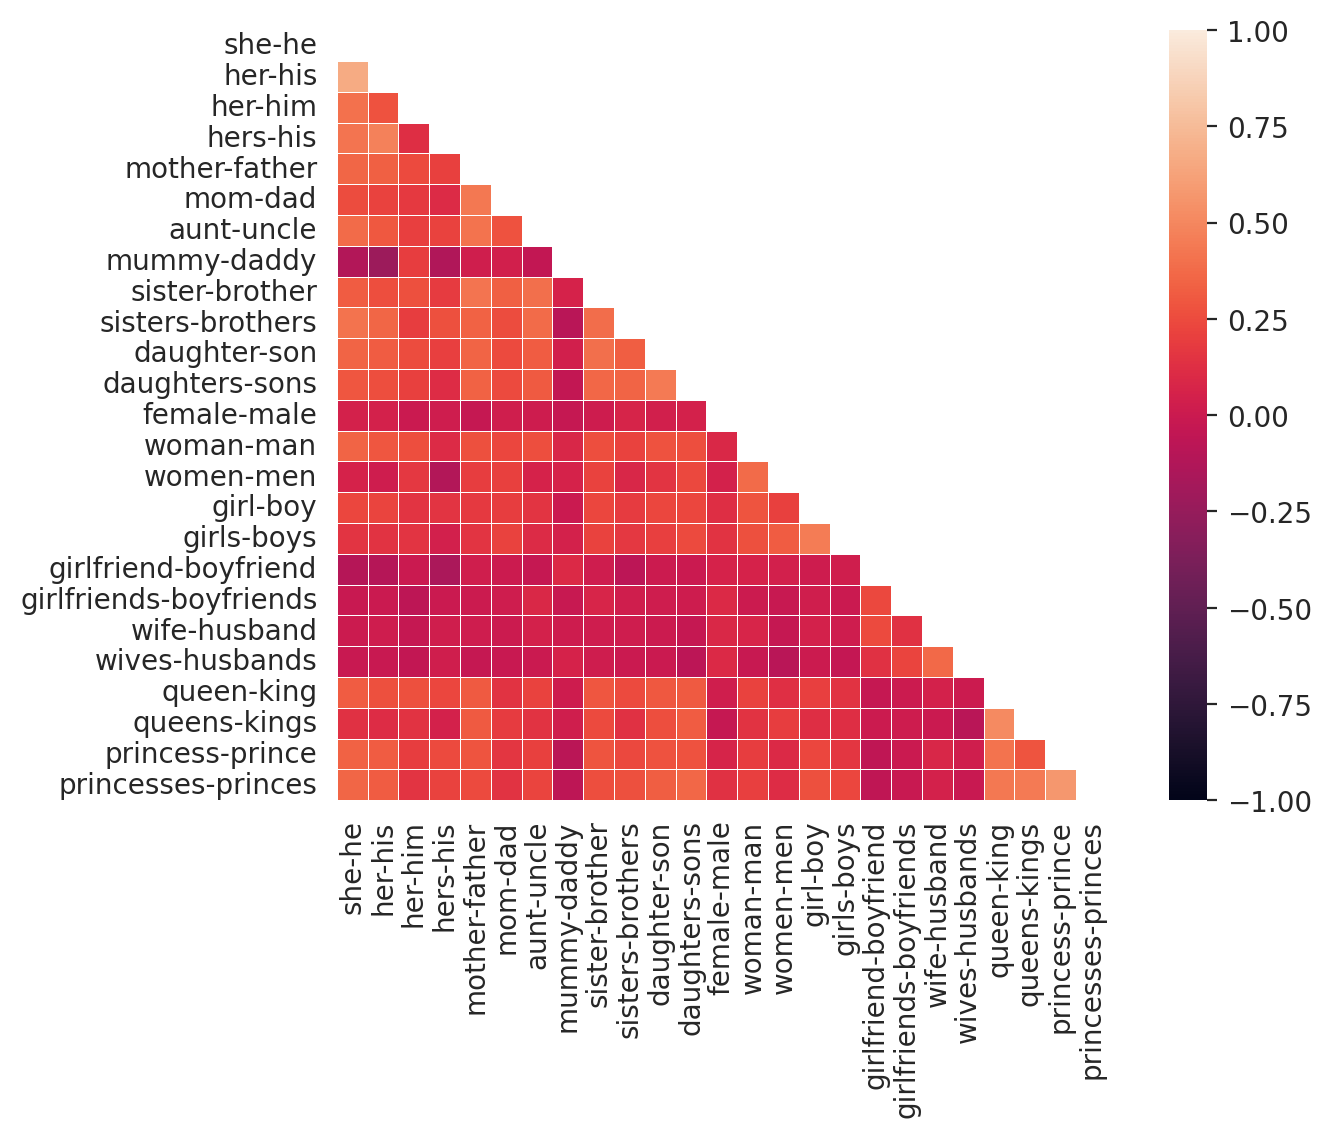

In [7]:
gender_pairs_subset, gender_pairs_subset_numwords = get_gender_pairs_matrix(GENDER_PMI, GROUP_PAIRED_WORDLIST)
correlation_plot(gender_pairs_subset, vmin=-1, vmax=1, square=True, linewidths=.25)#, cbar_kws={"shrink": .25})

('she', 'he') pmi-defined words: 152515
('her', 'his') pmi-defined words: 152515
('her', 'him') pmi-defined words: 152515
('hers', 'his') pmi-defined words: 152515
Pair (grandmother, grandfather) doesn't exist...
Pair (grandma, grandpa) doesn't exist...
Pair (stepmother, stepfather) doesn't exist...
Pair (stepmom, stepdad) doesn't exist...
('mother', 'father') pmi-defined words: 152515
('mom', 'dad') pmi-defined words: 152515
('aunt', 'uncle') pmi-defined words: 152515
Pair (aunts, uncles) doesn't exist...
('mummy', 'daddy') pmi-defined words: 152515
('sister', 'brother') pmi-defined words: 152515
('sisters', 'brothers') pmi-defined words: 152515
('daughter', 'son') pmi-defined words: 152515
('daughters', 'sons') pmi-defined words: 152515
('female', 'male') pmi-defined words: 152515
Pair (females, males) doesn't exist...
Pair (feminine, masculine) doesn't exist...
('woman', 'man') pmi-defined words: 152515
('women', 'men') pmi-defined words: 152515
Pair (madam, sir) doesn't exist...
Pa

/home/cbelem/.conda/envs/py39/lib/python3.9/site-packages/scipy/stats/_stats_py.py:5218: RuntimeWarning: overflow encountered in scalar multiply
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


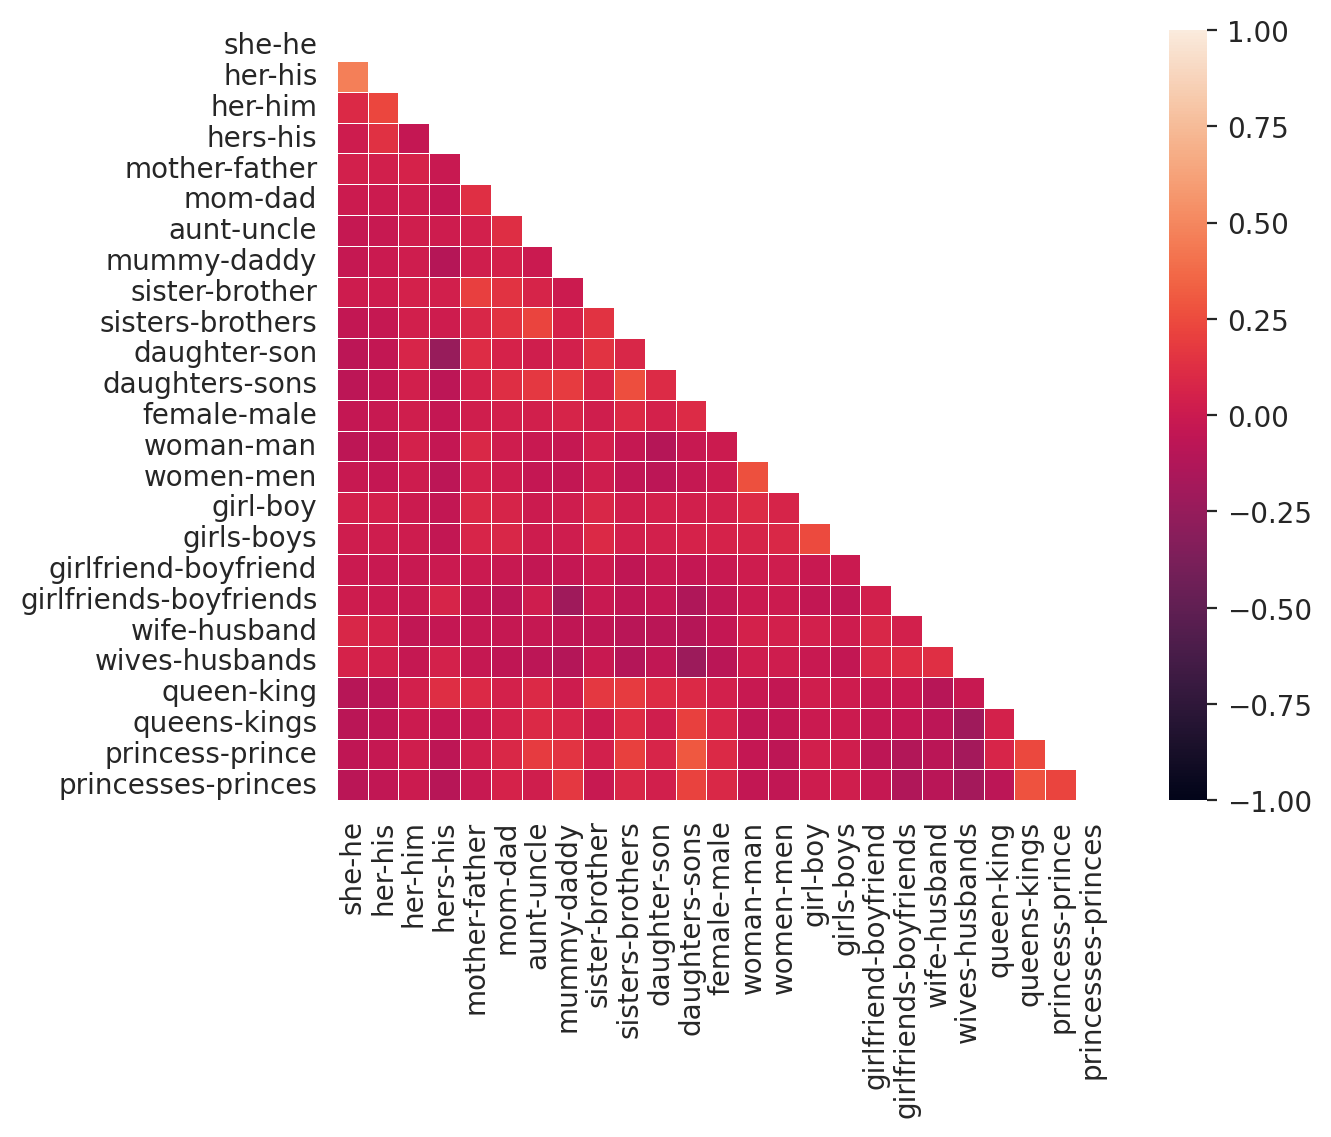

In [8]:
gender_pairs_all, gender_pairs_subset_clip_numwords = get_gender_pairs_matrix(GENDER_PMI, GROUP_PAIRED_WORDLIST, clip=5)# , missing_val=-50)
correlation_plot(gender_pairs_all, vmin=-1, vmax=1, square=True, linewidths=.25)#, cbar_kws={"shrink": .25})

In [16]:
GENDER_PMI.describe()

,pmi__her,pmi__his,pmi__him,pmi__hers,pmi__mother,pmi__father,pmi__mom,pmi__dad,pmi__mummy,pmi__daddy,...,pmi__queen,pmi__king,pmi__queens,pmi__kings,pmi__princess,pmi__prince,pmi__princesses,pmi__princes,pmi__he,pmi__she
count,80439.000000,98771.000000,65608.000000,7537.000000,30706.000000,29684.000000,10998.000000,10495.000000,1717.000000,2977.000000,...,10119.000000,19446.000000,3313.000000,6617.000000,5412.000000,8203.000000,1266.000000,3825.000000,100828.000000,66891.000000
mean,-24.827642,-24.861843,-24.803681,-24.205257,-24.915487,-24.912725,-25.195694,-25.311220,-24.439117,-25.298108,...,-25.361834,-25.395301,-24.835216,-24.729553,-25.019586,-25.328138,-23.698000,-23.932025,-25.416424,-25.262707
std,1.563299,1.580690,1.506580,1.445382,1.324532,1.342077,1.403486,1.310585,1.538892,1.450787,...,1.435780,1.500407,1.723579,1.696653,1.477100,1.462137,1.718849,1.715749,1.514534,1.499545
min,-33.499275,-33.331670,-33.613325,-30.640672,-30.936595,-30.878193,-30.376505,-30.894450,-29.312282,-30.237593,...,-30.485745,-31.237119,-28.636829,-29.793686,-30.302262,-31.337065,-30.067307,-29.995963,-32.885207,-33.474327
25%,-25.685422,-25.682861,-25.638325,-25.184315,-25.755291,-25.742207,-26.175983,-26.204275,-25.419204,-26.245775,...,-26.331394,-26.407824,-25.942235,-25.915272,-26.010199,-26.314027,-24.823475,-25.134534,-26.219694,-26.079852
50%,-24.622905,-24.552552,-24.605622,-24.219955,-24.857188,-24.823301,-25.178166,-25.242244,-24.648881,-25.315466,...,-25.429962,-25.440690,-25.287083,-24.966771,-25.088823,-25.347642,-24.085664,-24.178638,-25.137871,-25.078310
75%,-23.743398,-23.767377,-23.746094,-23.240134,-24.040494,-24.000929,-24.242664,-24.399705,-23.807955,-24.462129,...,-24.524708,-24.469532,-24.229567,-23.792893,-24.122755,-24.380551,-22.893234,-22.914827,-24.351869,-24.212292
max,-20.458226,-20.727246,-19.520618,-18.544282,-18.927156,-19.795987,-17.653614,-18.349328,-16.823430,-15.609870,...,-17.835727,-18.720616,-16.770424,-17.806201,-17.986234,-18.367298,-15.972031,-16.816626,-20.899774,-21.228257


In [22]:
len(GENDER_PMI["pmi__she"].dropna()) / len(GENDER_PMI["pmi__she"])

0.43858636855391275

In [23]:
len(GENDER_PMI["pmi__he"].dropna()) / len(GENDER_PMI["pmi__he"])

0.6611021866701636

In [104]:
counts = pd.read_csv("./pmi_file_w_counts.csv", index_col=0)
freq_she = counts.loc[counts["word"]=="she", "freq"].item()
freq_he = counts.loc[counts["word"]=="he", "freq"].item()
np.log(freq_she), np.log(freq_he)

(-6.082592952132149, -5.264963030594138)

-6.082592952132149
-5.264963030594138


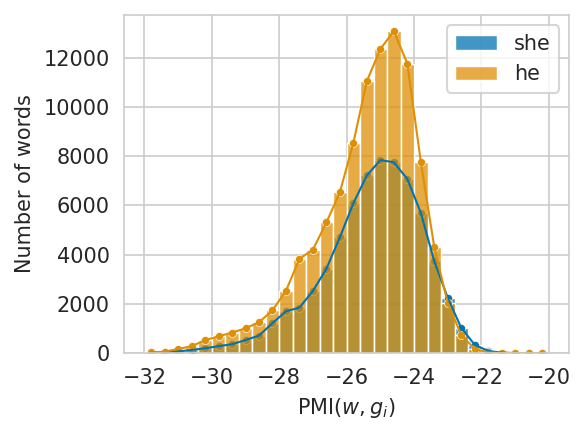

In [205]:
def get_histplot(pmi_df, col, bins, counts=None, binrange=None, **kwargs):
    upperbound = None
    word = col.split("__")[-1]
    if counts is not None:
        upperbound = np.log(counts.loc[counts["word"]==word, "freq"].item())
        if binrange and upperbound not in binrange:
            print(upperbound)
            upperbound = None
    
    ax = sns.histplot(data=pmi_df, x=col, bins=bins, kde=False, label=word, binrange=binrange, **kwargs)
    
    if upperbound is not None:
        plt.axvline(upperbound, ls="--", **kwargs)
    
    # Calculate bin midpoints
    counts, bin_edges = np.histogram(pmi_df[col].dropna(), bins=bins, range=binrange)
    bin_midpoints = (bin_edges[1:] + bin_edges[:-1]) / 2

    # Create a line connecting the midpoints
    sns.scatterplot(x=bin_midpoints, y=counts, **kwargs, s=15)
    sns.lineplot(x=bin_midpoints, y=counts, **kwargs, lw=1)
    
    
palette = sns.color_palette("colorblind", n_colors=2)
plt.figure(figsize=(4,3), dpi=150)
get_histplot(GENDER_PMI, "pmi__she", 30, counts, color=palette[0], binrange=(-32, -20))
get_histplot(GENDER_PMI, "pmi__he", 30, counts, color=palette[1], binrange=(-32, -20))
plt.ylabel("Number of words")
plt.xlabel("$\mathrm{PMI}(w, g_i)$")
plt.tight_layout()
plt.show()

(-34.0, -20.0)

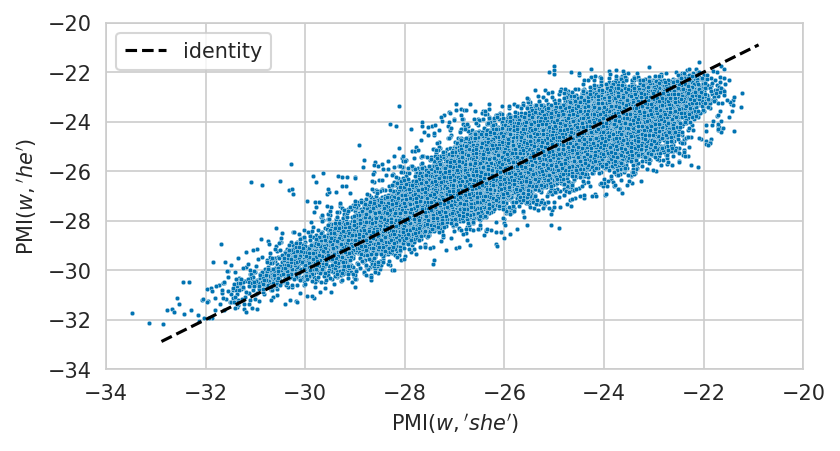

In [223]:
plt.figure(figsize=(6, 3), dpi=150)
sns.scatterplot(GENDER_PMI, x="pmi__she", y="pmi__he", s=5)
sns.lineplot(GENDER_PMI, x="pmi__he", y="pmi__he", ls="--", color="black", label="identity")
plt.xlabel("$\mathrm{PMI}(w, 'she')$")
plt.ylabel("$\mathrm{PMI}(w, 'he')$")
plt.xlim(-34, -20)
plt.ylim(-34, -20)

In [238]:
(len(counts) / len(GENDER_PMI)), len(GENDER_PMI)

(0.432180441268072, 152515)

Text(0, 0.5, "$\\mathrm{PMI}(w, 'she')$")

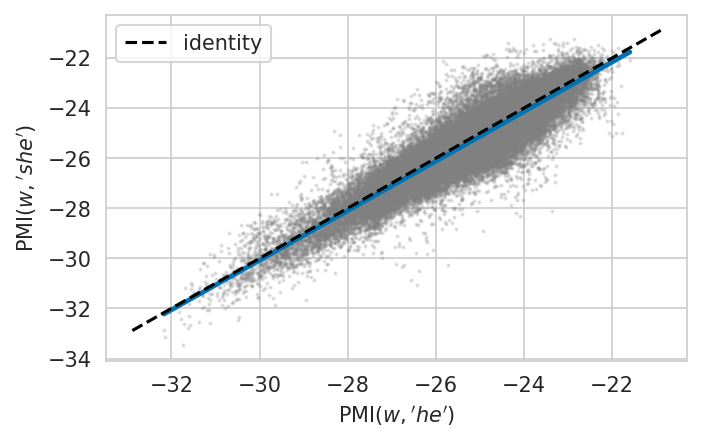

In [232]:
plt.figure(figsize=(5, 3), dpi=150)
sns.regplot(GENDER_PMI, x="pmi__he", y="pmi__she", scatter_kws={"s": 1, "alpha": 0.2, "color": "gray", "edgecolors": None})
sns.lineplot(GENDER_PMI, x="pmi__he", y="pmi__he", ls="--", color="black", label="identity")
plt.xlabel("$\mathrm{PMI}(w, 'he')$")
plt.ylabel("$\mathrm{PMI}(w, 'she')$")

Text(37.597222222222214, 0.5, "$\\mathrm{PMI}(w, 'she')$")

<Figure size 750x450 with 0 Axes>

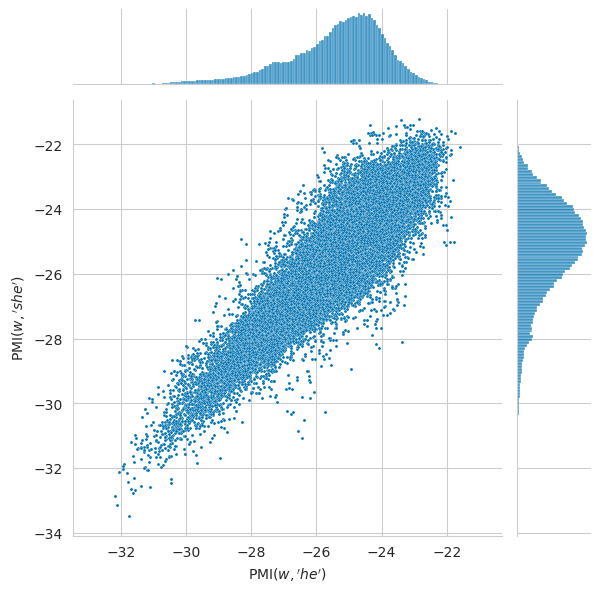

In [234]:
plt.figure(figsize=(5, 3), dpi=150)
sns.jointplot(GENDER_PMI, x="pmi__he", y="pmi__she", s=5, edgecolors=None)#, scatter_kws={"s": 1, "alpha": 0.2, "color": "gray", "edgecolors": None})
plt.xlabel("$\mathrm{PMI}(w, 'he')$")
plt.ylabel("$\mathrm{PMI}(w, 'she')$")

Text(0, 0.5, "$\\mathrm{PMI}(w, 'he')$")

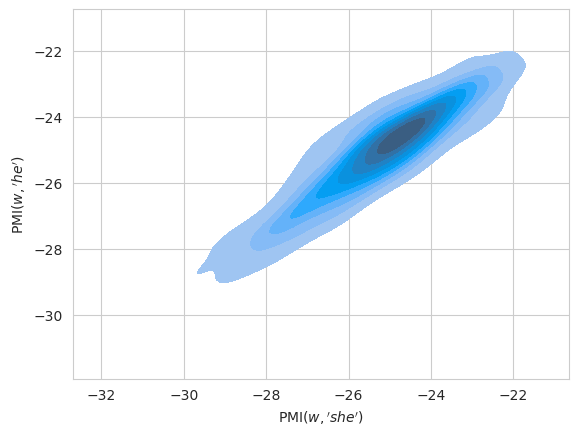

In [226]:
# plt.figure(figsize=(6, 3), dpi=150)
sns.kdeplot(GENDER_PMI.sample(1000), x="pmi__she", y="pmi__he", fill=True)
plt.xlabel("$\mathrm{PMI}(w, 'she')$")
plt.ylabel("$\mathrm{PMI}(w, 'he')$")

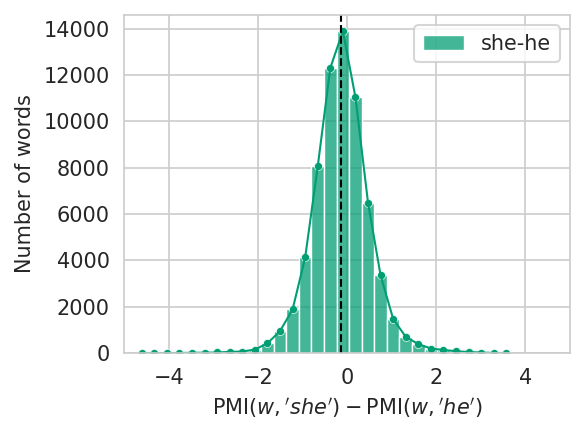

In [209]:
palette = sns.color_palette("colorblind", n_colors=3)
plt.figure(figsize=(4,3), dpi=150)
get_histplot(gender_pairs_subset, "she-he", 30, color=palette[2])

mean_val = gender_pairs_subset["she-he"].mean()
plt.axvline(mean_val, ls="--", color="black", lw=1)
plt.ylabel("Number of words")
plt.xlabel("$\mathrm{PMI}(w, 'she') - \mathrm{PMI}(w, 'he')$")
plt.xlim(-5, 5)
plt.tight_layout()
plt.legend()
plt.show()

In [197]:
gender_pairs_subset_counts = counts.set_index("word").join(gender_pairs_subset, how="left").sort_values("freq", ascending=False)
gender_pairs_corr = gender_pairs_subset_counts.corr("kendall")
gender_pairs_corr_cols = gender_pairs_corr.columns[3:]
gender_pairs_corr[gender_pairs_corr.index == "freq"][gender_pairs_corr_cols].T.describe()

,freq
count,25.000000
mean,-0.023016
std,0.103282
min,-0.339002
25%,-0.066227
50%,0.002841
75%,0.043337
max,0.141084


<AxesSubplot: xlabel='freq', ylabel='hers-his'>

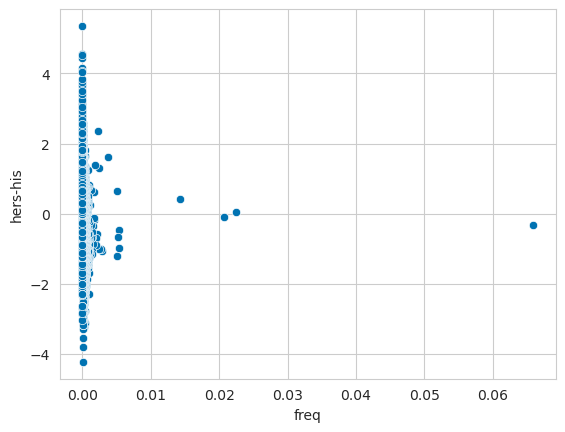

In [192]:
sns.scatterplot(gender_pairs_subset_counts, x="freq", y="hers-his")

-6.039881478375518
-5.577328140488633


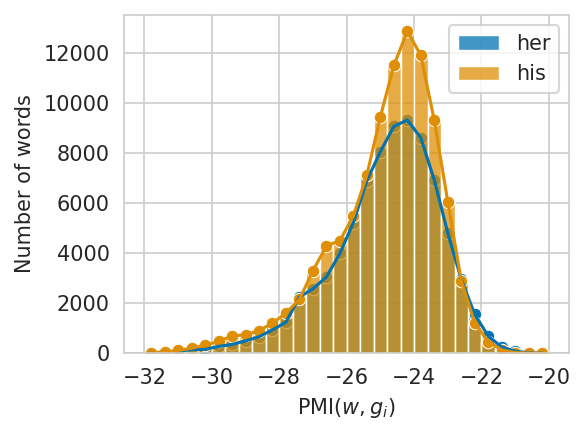

In [169]:
plt.figure(figsize=(4,3), dpi=150)
get_histplot(GENDER_PMI, "pmi__her", 30, counts, color=palette[0], binrange=(-32, -20))
get_histplot(GENDER_PMI, "pmi__his", 30, counts, color=palette[1], binrange=(-32, -20))
plt.ylabel("Number of words")
plt.xlabel("$\mathrm{PMI}(w, g_i)$")
plt.tight_layout()
plt.show()

-6.039881478375518
-6.577318972773651


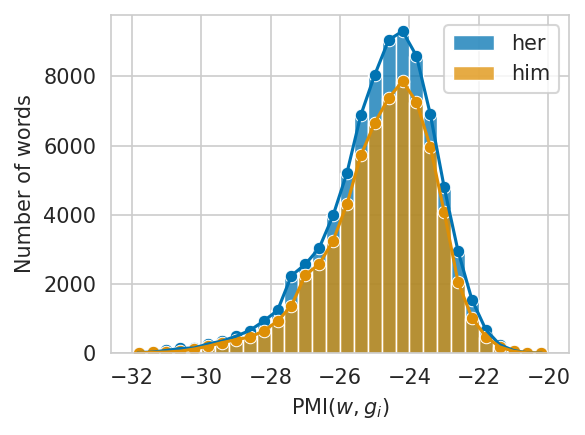

In [156]:
plt.figure(figsize=(4,3), dpi=150)
get_histplot(GENDER_PMI, "pmi__her", 30, counts, color=palette[0], binrange=(-32, -20))
get_histplot(GENDER_PMI, "pmi__him", 30, counts, color=palette[1], binrange=(-32, -20))
plt.ylabel("Number of words")
plt.xlabel("$\mathrm{PMI}(w, g_i)$")
plt.tight_layout()
plt.show()

-8.426021859912117
-8.409887634123148


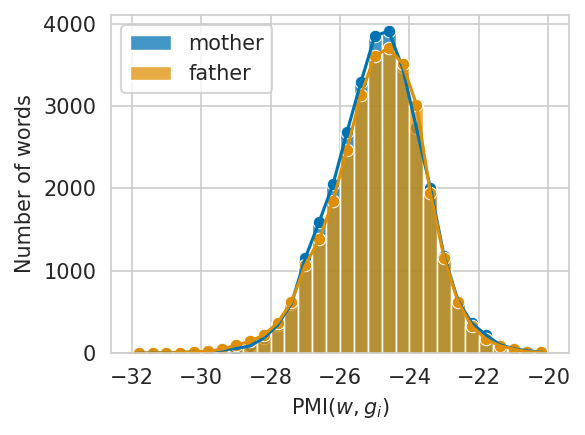

In [157]:
plt.figure(figsize=(4,3), dpi=150)
get_histplot(GENDER_PMI, "pmi__mother", 30, counts, color=palette[0], binrange=(-32, -20))
get_histplot(GENDER_PMI, "pmi__father", 30, counts, color=palette[1], binrange=(-32, -20))
plt.ylabel("Number of words")
plt.xlabel("$\mathrm{PMI}(w, g_i)$")
plt.tight_layout()
plt.show()

-9.31660260792874
-8.600761330391695


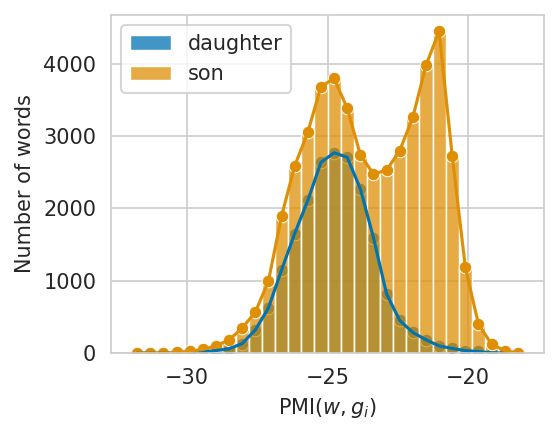

In [159]:
plt.figure(figsize=(4,3), dpi=150)
get_histplot(GENDER_PMI, "pmi__daughter", 30, counts, color=palette[0], binrange=(-32, -18))
get_histplot(GENDER_PMI, "pmi__son", 30, counts, color=palette[1], binrange=(-32, -18))
plt.ylabel("Number of words")
plt.xlabel("$\mathrm{PMI}(w, g_i)$")
plt.tight_layout()
plt.show()

-9.787097320202504
-9.761629396696213


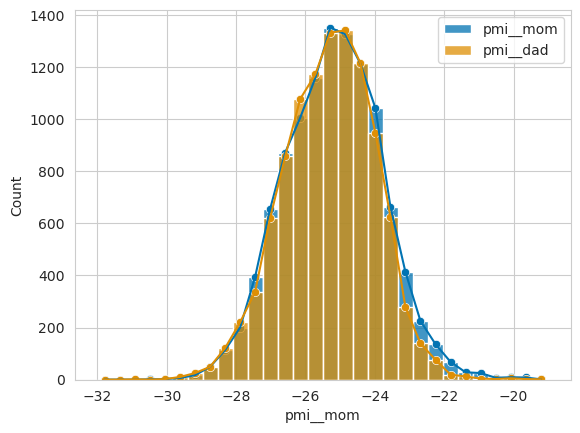

In [127]:
get_histplot(GENDER_PMI, "pmi__mom", 30, counts,color=palette[0], binrange=(-32,-19))
get_histplot(GENDER_PMI, "pmi__dad", 30, counts,color=palette[1], binrange=(-32, -19))

-8.866045424747456
-9.274645277662488


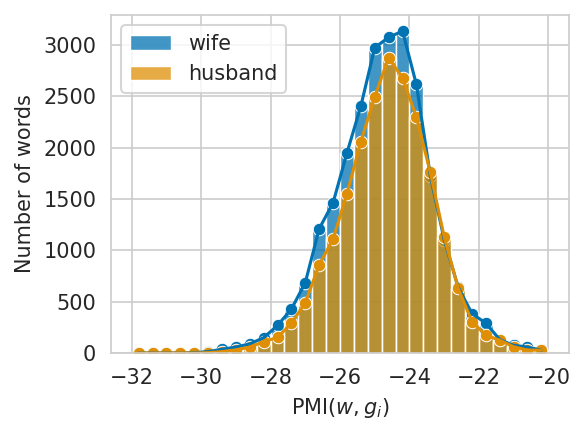

In [160]:
plt.figure(figsize=(4,3), dpi=150)
get_histplot(GENDER_PMI, "pmi__wife", 30, counts, color=palette[0], binrange=(-32, -20))
get_histplot(GENDER_PMI, "pmi__husband", 30, counts, color=palette[1], binrange=(-32, -20))
plt.ylabel("Number of words")
plt.xlabel("$\mathrm{PMI}(w, g_i)$")
plt.tight_layout()
plt.show()

-8.930781742101695
-9.134718377148646


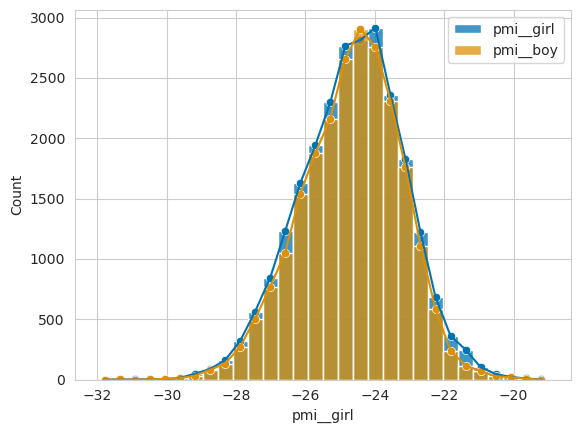

In [126]:
get_histplot(GENDER_PMI, "pmi__girl", 30, counts,color=palette[0], binrange=(-32,-19))
get_histplot(GENDER_PMI, "pmi__boy", 30, counts,color=palette[1], binrange=(-32, -19))

## Having settled on a specific gender diff PMI 

Say, PMI_DIFF(w, she, he), let us now compute the pmi of the words used for each of the benchmarks.

In [9]:
# ideally this will be the same base dir as before, once we put this into a repository we can update this
BASE_DIR = ".."

In [239]:
print("== Number of Words ==")
# we use the same words for all the templates
OUR_WORDS = pd.read_csv(f"{BASE_DIR}/results-words5/final-results/revised_templates.csv", index_col=0)
# comment the line below to remove the filtering by is_natural (it differs in the words : {'dudgeon', 'forfend'})
OUR_WORDS = OUR_WORDS[OUR_WORDS["is_natural"]]["word"].unique()
print("Ours:", len(OUR_WORDS))

# --------------------------------------------------
# Read Winobias and apply some post processing
# --------------------------------------------------
WINOBIAS_WORDS = pd.read_csv(f"{BASE_DIR}/results-baselines/coref__Winobias__templates.dev.csv", index_col=0)
WINOBIAS_WORDS = WINOBIAS_WORDS["word"].apply(lambda x: x.split()[-1].lower()).unique()
print("WinoBias:", len(WINOBIAS_WORDS))

# --------------------------------------------------
# Read Winogender and apply some post processing
# --------------------------------------------------
WINOGENDER_WORDS = pd.read_csv(f"{BASE_DIR}/results-baselines/coref__Winogender__templates.csv", index_col=0)
WINOGENDER_WORDS = np.unique(
    # Sentences are constructed based on two attribute words, so we'll consider both :3
    WINOGENDER_WORDS["example_id"].apply(lambda x: x.split(".")[0].lower()).unique().tolist()
    + WINOGENDER_WORDS["example_id"].apply(lambda x: x.split(".")[1].lower()).unique().tolist()
)
print("Winogender:", len(WINOGENDER_WORDS))

# --------------------------------------------------
# Read Stereoset and apply some post processing
# --------------------------------------------------
STEREOSET_WORDS = pd.read_csv(f"{BASE_DIR}/results-baselines/lm__StereoSet_pronouns_only.csv")["word"].unique()
print("Stereoset (gender, pronoun subset):", len(STEREOSET_WORDS))

# --------------------------------------------------
# Read CROW-S Pairs and apply some post processing
# --------------------------------------------------
# We exclude Crow-S in a first stage because it doesn't really
# provide a clear annotation on what are the words. Since the
# templates were written by annotators. In the future, we
# can try to derive it heuristically using dependency trees
# guided by the main changei n the sentence 
# (e.g., if a pronoun is changed we can try to link that back to the entity it was depending or describing.)

== Number of Words ==
Ours: 491
WinoBias: 40
Winogender: 84
Stereoset (gender, pronoun subset): 82


In [248]:
np.random.seed(421)
sorted(np.random.choice(OUR_WORDS, 50, replace=False))

['addict',
 'angiography',
 'barbaric',
 'beauties',
 'bushed',
 'campsites',
 'cancelation',
 'carriages',
 'common',
 'contaminating',
 'controlling',
 'couldn',
 'deluge',
 'durational',
 'exploitative',
 'expressions',
 'fierce',
 'fireplaces',
 'focussed',
 'gemologist',
 'gnaw',
 'goofiness',
 'gree',
 'hawthorn',
 'headlands',
 'imaginary',
 'intoxicate',
 'jinxed',
 'laving',
 'oblivion',
 'omen',
 'overdrive',
 'requests',
 'responded',
 'rewire',
 'skaters',
 'solemn',
 'spidery',
 'splints',
 'sportswear',
 'spycraft',
 'stacks',
 'sting',
 'taste',
 'turns',
 'twitches',
 'understand',
 'understands',
 'wasted',
 'ween']

**Compute the embeddings of every word**: We will use fasttext models to compute a 300-dimensional embedding for every defined word in PMI_DIFF. We opt for char-level embedding as opposed to word-level embedding because we're dealing with words altered by suffixes and prefixes and for which there's sometimes not appropriate word embeddings.

In [11]:
import fasttext.util, functools
# fasttext.util.download_model('en', if_exists='ignore')
# !mv cc.en.300.bin /extra/ucinlp1/cbelem/fasttext/cc.en.300.bin
# character 5-grams
ft = fasttext.load_model('/extra/ucinlp1/cbelem/fasttext/cc.en.300.bin')


def word_top1_nearest_neighbor(word: str, word2emb: dict) -> str:
    """Compute the specified word's nearest neighbor using the
    word-to-embedding mapping. This word-embedding mapping should
    be precomputed 
    """
    from sklearn.metrics.pairwise import cosine_similarity
    
    if word2emb.get(word) is not None:
        return word
    
    cand_words, cand_embs = zip(*word2emb.items())
    cand_embs = np.vstack(cand_embs)
    
    word_emb = ft.get_word_vector(word).reshape(1, -1)
    similarities = cosine_similarity(word_emb, cand_embs)
    return cand_words[np.argmax(similarities)]

In [12]:
# Word 2 pmi mapping
def collect_word_level_pmi(wordlist, pmi_diff: pd.DataFrame, nn_fn: callable, pmi_colname="pmi_diff"):
    word2pmi = pmi_diff[["word", pmi_colname]].set_index("word").to_dict()[pmi_colname]
    
    results = []
    approx_pairs = []
    results_w_approx = []
    for word in wordlist:
        
        if (pmi_val := word2pmi.get(word)) is not None:
            results.append(pmi_val)
            results_w_approx.append(pmi_val)
        else:
            cand_word = nn_fn(word)
            pmi_val = word2pmi.get(cand_word)
            
            results_w_approx.append(pmi_val)
            approx_pairs.append({"word": word, "approx": cand_word})
            
    return results, results_w_approx, approx_pairs


# If you plan to collect word level pmi based on PMI_DIFF
_PMI_REF = PMI_DIFF

# Compute the 300-dimensional word embedding representation for all words in PMI_DIFF
WORDS2EMB_FT = {w: ft.get_word_vector(w.strip()) for w in _PMI_REF.word.values.tolist()}
fasttext_nearest_neighbor = functools.partial(word_top1_nearest_neighbor, word2emb=WORDS2EMB_FT)

In [13]:
DATANAME_TO_WORDLIST = {
    "Ours": OUR_WORDS,
    "Winobias": WINOBIAS_WORDS,
    "Winogender": WINOGENDER_WORDS,
    "Stereoset": STEREOSET_WORDS,
}

# All the dataset names we're using in our analysis
DATANAMES = DATANAME_TO_WORDLIST.keys()

RESULTS = {"pmi": defaultdict(list), "len": {}, "missing": {}}
for name, wordlist in DATANAME_TO_WORDLIST.items():
    results, _, missing_words = collect_word_level_pmi(wordlist, pmi_diff=_PMI_REF, pmi_colname="pmi_diff", nn_fn=fasttext_nearest_neighbor)
    
    RESULTS["pmi"]["dataset"].extend([name] *len(results)) 
    RESULTS["pmi"]["pmi_val"].extend(results)
    
    RESULTS["len"][name] = len(results)
    RESULTS["missing"][name] = missing_words

### Hypothesis 1: Our words correlate less strongly with gender

In [ ]:
plt.figure(figsize=(5, 3), dpi=(200))
sns.boxplot(pd.DataFrame(RESULTS["pmi"]), x="dataset", y="pmi_val")
plt.xlabel("Dataset name")
plt.ylabel("PMI difference")
plt.ylim(-2, 2.1)
plt.tight_layout()
plt.show()

In [ ]:
pd.DataFrame(RESULTS["pmi"]).groupby("dataset").count()

In [ ]:
_df = pd.DataFrame(RESULTS["pmi"])
_df["pmi_val_abs"] = _df["pmi_val"].apply(np.abs)
_df.sort_values("pmi_val_abs", ascending=False).groupby("dataset").head(1)

In [ ]:
_df.sort_values("pmi_val_abs", ascending=False).groupby("dataset").max()

### Hypothesis 2: Our words are more diverse than other studies



In [ ]:
import itertools
from collections import Counter

diversity_results = defaultdict(list)
for name1, name2 in itertools.product(DATANAMES, DATANAMES):
    
    if name1 == name2:
        diversity_results["jaccard_similarity"].append(1)
    else:
        words1 = Counter(DATANAME_TO_WORDLIST[name1])
        words2 = Counter(DATANAME_TO_WORDLIST[name2])
        diversity_results["jaccard_similarity"].append(len(words1 & words2) / len(words1 | words2))
        
    diversity_results["dataset1"].append(name1)
    diversity_results["dataset2"].append(name2)
    
diversity_results = pd.DataFrame(diversity_results)
jacc_sim_table = diversity_results.pivot(index="dataset1", columns="dataset2", values=["jaccard_similarity"])
jacc_sim_table.to_csv("./tables/word_level__jaccardsimilarity.csv", index=None)

# Note that while the stereoset does not have any jaccard similarity with the other datasets
# we found that there is high similarity and also there are some gendered expressions.
print(jacc_sim_table.droplevel(level=None, axis=1).to_latex(
    float_format="%.2f",
    caption="Attribute lexicon overlap (as determined by the Jaccard Similarity coefficient).",
    label="tab:word-level-jacc-similarity-no-stem",
))

It may be more meaningful to remove the plurals of the words and ensure everything is in the same format. Maybe more aggressively, we can also apply the lancaster stemmer (since it also reduces words like anorexia and anorexic to the same root).

In [ ]:
from nltk import SnowballStemmer
snow_stemmer = SnowballStemmer(language='english')

DATANAME_TO_STEMLIST = {name: [snow_stemmer.stem(w) for w in wordlist] for name, wordlist in DATANAME_TO_WORDLIST.items()}

diversity_results = defaultdict(list)
for name1, name2 in itertools.product(DATANAMES, DATANAMES):
    
    if name1 == name2:
        diversity_results["jaccard_similarity"].append(1)
    else:
        words1 = Counter(DATANAME_TO_STEMLIST[name1])
        words2 = Counter(DATANAME_TO_STEMLIST[name2])
        diversity_results["jaccard_similarity"].append(len(words1 & words2) / len(words1 | words2))
        
    diversity_results["dataset1"].append(name1)
    diversity_results["dataset2"].append(name2)
    
diversity_results = pd.DataFrame(diversity_results)
jacc_sim_table = diversity_results.pivot(index="dataset1", columns="dataset2", values=["jaccard_similarity"])
jacc_sim_table.to_csv("./tables/word_level__snowballstem_jaccardsimilarity.csv", index=None)

# Note that while the stereoset does not have any jaccard similarity with the other datasets
# we found that there is high similarity and also there are some gendered expressions.
print(jacc_sim_table.droplevel(level=None, axis=1).to_latex(
    float_format="%.2f",
    caption="Attribute lexicon overlap (as determined by the Jaccard Similarity coefficient). The lexicon was normalized by applying Snowball Stemmer.",
    label="tab:word-level-jacc-similarity-snowball-stem",
))
jacc_sim_table

In [ ]:
plt.figure(figsize=(3, 3), dpi=(200))
sns.barplot(pd.DataFrame(RESULTS["len"].items(), columns=["dataset", "num_words"]), y="dataset", x="num_words")
plt.xlabel("Number of attribute words")
plt.ylabel("Dataset")
plt.tight_layout()
plt.savefig("./images/word_level__barplot_num_words_per_dataset.png")
plt.show()

In [ ]:
import itertools

d = pd.DataFrame(RESULTS["pmi"])
d = d.sort_values(["dataset", "pmi_val"])
d["pmi_val_abs"] = d["pmi_val"].apply(np.abs)

# Plot the increase in the epsilon (from 0 to 2.5) and the impact in the number of words included
epsilons = np.linspace(0, 2.1, 101)

diversity_results = defaultdict(list)
for dataset, eps in itertools.product(DATANAME_TO_WORDLIST.keys(), epsilons):
    counts = ((d["pmi_val_abs"] <= eps) & (d["dataset"] == dataset)).sum() 
    diversity_results["dataset"].append(dataset)
    diversity_results["num_words"].append(counts)
    diversity_results["epsilon"].append(eps)
    
diversity_results = pd.DataFrame(diversity_results)
sns.lineplot(diversity_results, x="epsilon", y="num_words", hue="dataset")
plt.xlabel("Gender Correlation Strength ($\epsilon_P$)")
plt.ylabel("Number of attribute words")
plt.tight_layout()
plt.savefig("./images/word_level__num_words_by_gendercorrelation.png")
plt.show()

In [ ]:
d = pd.DataFrame(RESULTS["pmi"])
d = d.sort_values(["dataset", "pmi_val"])
d["pmi_val_abs"] = d["pmi_val"].apply(np.abs)

diversity_results = defaultdict(list)
for dataset, eps in itertools.product(DATANAME_TO_WORDLIST.keys(), epsilons):
    freq = ((d["pmi_val_abs"] <= eps) & (d["dataset"] == dataset)).sum() / len(DATANAME_TO_WORDLIST[dataset])
    diversity_results["dataset"].append(dataset)
    diversity_results["num_words"].append(freq)
    diversity_results["epsilon"].append(eps)
    
diversity_results = pd.DataFrame(diversity_results)
sns.lineplot(diversity_results, x="epsilon", y="num_words", hue="dataset")
plt.xlabel("Correlation Strength with Gender ($\epsilon_P$)")
plt.ylabel("% of attribute words")

plt.tight_layout()
plt.savefig("./images/word_level__freq_words_by_gendercorrelation.png")
plt.show()

### Hypothesis 3: The selected words are not that similar to the ones in other studies

In [ ]:
DATANAME_TO_WORD_EMB = {
    name: np.vstack([WORDS2EMB_FT[w] for w in wordlist if WORDS2EMB_FT.get(w) is not None])
    for name, wordlist in DATANAME_TO_WORDLIST.items()
}

# All the dataset names we're using in our analysis
DATANAMES = DATANAME_TO_WORD_EMB.keys()
DATANAMES

#### Average distance

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

semantics_corr = defaultdict(list)
for name1, name2 in itertools.product(DATANAMES,DATANAMES):
    if name1 == name2:
        semantics_corr["similarity"].append(1)
    else:
        sim = cosine_similarity(DATANAME_TO_WORD_EMB[name1], DATANAME_TO_WORD_EMB[name2])
        # sim will be a matrix of size num_words_in_name1 x num_words_in_name2
        
        # let's compute the average distance of the 
        semantics_corr["similarity"].append(np.abs(sim).mean(axis=1).mean())

    semantics_corr["dataset1"].append(name1)
    semantics_corr["dataset2"].append(name2)
    
semantics_corr = pd.DataFrame(semantics_corr)
semantics_corr.pivot(index="dataset1", columns="dataset2", values=["similarity"])

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

semantics_corr = defaultdict(list)

for name1, name2 in itertools.product(DATANAMES,DATANAMES):
    if name1 == name2:
        semantics_corr["similarity"].append(1)
    else:
        sim = cosine_similarity(DATANAME_TO_WORD_EMB[name1], DATANAME_TO_WORD_EMB[name2])
        # sim will be a matrix of size num_words_in_name1 x num_words_in_name2
        # let's compute the average distance of the 
        semantics_corr["similarity"].append(np.median(np.abs(sim).max(axis=1)))

    semantics_corr["dataset1"].append(name1)
    semantics_corr["dataset2"].append(name2)
    
semantics_corr = pd.DataFrame(semantics_corr)
corr_table = semantics_corr.pivot(index="dataset1", columns="dataset2", values=["similarity"])
corr_table.to_csv("./tables/word_level__avg_max_fasttext_wordtoword_cosine_similarity.csv", index=None)
print(corr_table.droplevel(level=None, axis=1).to_latex(
    float_format="%.2f",
    caption="Average distribution of the cosine similarity with the nearest neighboring word (as determined by \\texttt{fasttext}).",
    label="tab:word-level-avg-nearestneighbor-cosine-sim",
))

In [ ]:
# TODO 
# - get a few qualitative examples of what are the most similar words..

In [ ]:
gendered_words_results = defaultdict(list)

gendered_words = {}
for name, wordlist in DATANAME_TO_WORDLIST.items():   
    gendered_words[name] = {
        "female": Counter(FEMALE_WORDS) & Counter(wordlist),
        "male": Counter(MALE_WORDS) & Counter(wordlist),
    }
    
    gendered_words_results["counts"].append(len(gendered_words[name]["female"]))
    gendered_words_results["counts"].append(len(gendered_words[name]["male"]))
    gendered_words_results["gender"].extend(["female", "male"])
    gendered_words_results["dataset"].extend([name, name])


gendered_words_results = pd.DataFrame(gendered_words_results)
gendered_words_results.groupby("dataset").sum()

In [ ]:
gendered_words

In [ ]:
TOP = 5

# Necessary bcause some words are not defined and if we use indices then
# we wont be able to map it back
_DATANAME_TO_WORDLIST = {
    name: np.vstack([w for w in wordlist if WORDS2EMB_FT.get(w) is not None])
    for name, wordlist in DATANAME_TO_WORDLIST.items()
}


semantics_corr = defaultdict(list)
semantics_words = defaultdict(list)

for name1, name2 in itertools.product(DATANAMES,DATANAMES):
    if name1 == name2:
        semantics_corr["similarity"].append(1)
    else:
        sim = cosine_similarity(DATANAME_TO_WORD_EMB[name1], DATANAME_TO_WORD_EMB[name2])
        # sim will be a matrix of size num_words_in_name1 x num_words_in_name2
        sim_values = np.abs(sim)
        top_idx = np.argsort(sim_values, axis=1)[:,-TOP:]
        for i, row in enumerate(top_idx):
            top_related = (np.array(_DATANAME_TO_WORDLIST[name2])[row]).tolist()
            top_related = [(w, sim[i, j]) for w, j in zip(top_related, row)]
            
            semantics_words[f"{name1}__{name2}"].append((_DATANAME_TO_WORDLIST[name1][i][0], top_related))
        # let's compute the average distance of the 
        semantics_corr["similarity"].append(f"{np.mean(sim_values.max(axis=1)):.2f} (± {np.std(sim_values.max(axis=1)):.2f})")

    semantics_corr["dataset1"].append(name1)
    semantics_corr["dataset2"].append(name2)
    
semantics_corr = pd.DataFrame(semantics_corr)
corr_table = semantics_corr.pivot(index="dataset1", columns="dataset2", values=["similarity"])
corr_table.to_csv("./tables/word_level__avg_max_fasttext_wordtoword_cosine_similarity.csv", index=None)
print(corr_table.droplevel(level=None, axis=1).to_latex(
    float_format="%.2f",
    caption="Average distribution of the cosine similarity with the nearest neighboring word (as determined by \\texttt{fasttext}).",
    label="tab:word-level-avg-nearestneighbor-cosine-sim",
))

In [ ]:
import pickle

with open(f"./others/top-{TOP}-similarwords.pkl", "wb") as f:
    pickle.dump(semantics_words, f)